In [1]:
# # Run this if you don’t have the dataset locally or in your drive.
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json  # Set permissions.
# !kaggle datasets download -d adityajn105/flickr8k
# !unzip flickr8k.zip # remove the first line in captions.txt (handled!)

In [2]:
# -*- coding: utf-8 -*-
import os
import cv2
import json
import csv
import random
import pickle
import string
from tqdm import tqdm
import numpy as np
from collections import Counter
from tqdm import tqdm
from PIL import Image
import fileinput
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    DetrFeatureExtractor,
    DetrForObjectDetection,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # Optimizes kernel selection


In [4]:
# # remove the first line of captions.txt
# with fileinput.input("captions.txt", inplace=True) as f:
#     for i, line in enumerate(f):
#         if i > 0:  # Skip the first line
#             print(line, end="")  # print writes to the file

In [5]:
################################################################################
# Setup
################################################################################

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

data_dir = os.path.join('E:\\', 'dataset30k') # or "dataset30K" if you have that dataset
images_dir = os.path.join(data_dir,'Images')
captions_path = os.path.join(data_dir,'captions.txt')


Using device: cuda
Device 0: NVIDIA GeForce GTX 1660 SUPER


In [6]:
# ------------------------------------------------------------------
# 1) Load the DETR + Swin transformer backbones for image feature extraction.
# ------------------------------------------------------------------

# Load and freeze Swin Transformer
swin_model = timm.create_model(
    "swin_large_patch4_window12_384", pretrained=True, num_classes=0
).to(device)
# swin_model.eval()
# for param in swin_model.parameters():
#     param.requires_grad = False

# Load and freeze DETR
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
# detr_model.eval()
# for param in detr_model.parameters():
#     param.requires_grad = False

C:\Users\Mohamed\anaconda3\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForO

In [7]:
################################################################################
# Utilities for loading captions and extracting features
################################################################################

def load_captions(filepath):
    """
    For Flickr-style captions: each line is "filename,caption".
    Returns a dict: { 'img_id': ['caption1','caption2', ...], ... }
    """
    captions_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) != 2:
                continue
            image_filename, caption = row
            image_id = image_filename.split('.')[0]
            if image_id not in captions_dict:
                captions_dict[image_id] = []
            captions_dict[image_id].append(caption.strip())
    return captions_dict

captions_dict = load_captions(captions_path)
image_ids = list(captions_dict.keys())
print(f"Number of images: {len(image_ids)}")

Number of images: 31783


In [8]:
# ------------------------------------------------------------------
# Swin + DETR feature extraction
# ------------------------------------------------------------------

def extract_swin_features(model, image_tensor):
    with torch.no_grad():
        feats = model(image_tensor)  # [batch_size, feature_dim]
    return feats.view(feats.size(0), -1)

def extract_detr_features(model, image_tensor, target_size=1536):
    """
    We take the decoder's last_hidden_state, flatten, and then optionally
    adaptive-pool to 1536 if needed.
    """
    with torch.no_grad():
        outputs = model(image_tensor)
        object_queries = outputs.last_hidden_state  # [batch_size, num_queries, hidden_dim]
        flattened = object_queries.view(object_queries.size(0), -1)

        if flattened.size(1) > target_size:
            flattened = F.adaptive_avg_pool1d(flattened.unsqueeze(0), target_size).squeeze(0)
    return flattened

In [9]:
################################################################################
# Transform for images
################################################################################

# Transforms used specifically for feature extraction at a fixed size
feature_extraction_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [10]:
################################################################################
# Pre-generate (and cache) image features. This avoids re-extracting them each epoch.
################################################################################

if data_dir == os.path.join('dataset'):
    features_file = 'featuresMixed8K.pkl'
    print("Using Flickr8k dataset features file.")
elif data_dir == os.path.join('E:\\', 'dataset30k'):
    features_file = 'featuresMixed30K.pkl'
    print("Using Flickr30k dataset features file.")
else:
    raise ValueError("Unrecognized dataset directory")
if os.path.exists(features_file):
    with open(features_file, "rb") as f:
        features_dict = pickle.load(f)
    print(f"Loaded precomputed features from {features_file}")
else:
    print("Extracting features from images with random train_transform. This may take a while...")
    features_dict = {}
    for img_id in tqdm(image_ids):
        img_path = os.path.join(images_dir, img_id + ".jpg")
        if not os.path.exists(img_path):
            continue

        # random augment
        img = Image.open(img_path).convert("RGB")
        tensor_img = feature_extraction_transform(img).unsqueeze(0).to(device)

        # SWIN
        swin_feats = extract_swin_features(swin_model, tensor_img)
        # DETR
        detr_feats = extract_detr_features(detr_model, tensor_img, target_size=1536)
        # combine
        combined = torch.cat([swin_feats, detr_feats], dim=1)  # [1, 3072]
        features_dict[img_id] = combined.squeeze(0).cpu()  # [3072]

    with open(features_file, "wb") as f:
        pickle.dump(features_dict, f)
    print(f"Saved extracted features to {features_file}")

feature_dim = 3072

Using Flickr30k dataset features file.
Loaded precomputed features from featuresMixed30K.pkl


In [11]:
# # Find all images that have at least one empty caption
# empty_captions = {img_id: caps for img_id, caps in captions_dict.items() if any(not cap.strip() for cap in caps)}

# # Print or return the results
# if empty_captions:
#     print("Images with empty captions:")
#     for img_id, caps in empty_captions.items():
#         print(f"Image ID: {img_id}, Captions: {caps}")
# else:
#     print("No empty captions found.")


In [12]:
################################################################################
# Dataset & Dataloader
################################################################################

from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

random.seed(42)
random.shuffle(image_ids)
N = len(image_ids)
train_end = int(0.9 * N)
val_end   = int(0.95 * N)

train_ids = image_ids[:train_end]
val_ids   = image_ids[train_end:val_end]
test_ids  = image_ids[val_end:]

print(f"Train size: {len(train_ids)}, Val size: {len(val_ids)}, Test size: {len(test_ids)}")

class FlickrDataset(Dataset):
    """
    We store *all* captions (5) per image in a single item, so:
      input_ids => [num_captions, max_len]
      attention_mask => [num_captions, max_len]
      features => [3072]
    """

    def __init__(self, image_ids, captions_dict, tokenizer, swin_model, detr_model, transform, image_dir, max_length=40):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.tokenizer = tokenizer
        self.swin_model = swin_model
        self.detr_model = detr_model
        self.transform = transform
        self.image_dir = image_dir
        self.max_length = max_length

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        # pick one random caption from the set for this image
        cap_list = self.captions_dict[img_id]
        caption = random.choice(cap_list)


        encoding = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)        # [max_length]
        attention_mask = encoding["attention_mask"].squeeze(0)  # [max_length]

         # Load image and apply transformations
        image_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        image = image.unsqueeze(0)    # Add batch dimension: shape becomes [1, C, H, W]
        image = image.to(device)
        # Extract features using Swin Transformer and DETR with transformed image
        swin_features = extract_swin_features(self.swin_model, image).to(device)
        detr_features = extract_detr_features(self.detr_model, image).to(device)
        # Combine features
        features = torch.cat([swin_features, detr_features], dim=1)
        return {
            "img_id": img_id,
            "features": features,            # [3072]
            "input_ids": input_ids,          # [num_captions, max_length]
            "attention_mask": attention_mask # [num_captions, max_length]
        }


Train size: 28604, Val size: 1589, Test size: 1590


C:\Users\Mohamed\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
def collate_fn(batch):
    """
    Merges a list of samples to form a mini-batch.
    Each item in `batch` is a dict from __getitem__.
    """
    # Filter out any Nones if present
    batch = [b for b in batch if b is not None]

    # Stack image features
    features = torch.stack([b["features"] for b in batch])  # [B, 3072]

    # For text data, we already have them as equal-length by max_length
    input_ids = torch.stack([b["input_ids"] for b in batch])
    attention_mask = torch.stack([b["attention_mask"] for b in batch])

    return {
        "features": features.to(device),
        "input_ids": input_ids.to(device),
        "attention_mask": attention_mask.to(device),
    }

train_dataset = FlickrDataset(train_ids, captions_dict, tokenizer, swin_model, detr_model, feature_extraction_transform, images_dir, 40)
val_dataset = FlickrDataset(val_ids, captions_dict, tokenizer, swin_model, detr_model, feature_extraction_transform, images_dir, 40)
test_dataset = FlickrDataset(test_ids, captions_dict, tokenizer, swin_model, detr_model, feature_extraction_transform, images_dir, 40)


batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [14]:
################################################################################
# GPT-2 Model for Image Captioning
################################################################################

class GPT2CaptioningModel(nn.Module):
    """
    We map the 3072-d image features to GPT-2's hidden size
    and prepend that as a "prefix embedding." Then GPT-2
    generates a caption from that prefix.
    """

    def __init__(self, feature_dim=3072, gpt2_name="gpt2"):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_name)
        self.gpt2.resize_token_embeddings(len(tokenizer))
        self.gpt2.config.pad_token_id = tokenizer.eos_token_id

        gpt2_hidden_size = self.gpt2.config.n_embd
        self.linear = nn.Linear(feature_dim, gpt2_hidden_size)

        
    def forward(self, features, input_ids, attention_mask, labels=None):
        """
        features: [batch_size, 3072]
        input_ids: [batch_size, seq_len]
        attention_mask: [batch_size, seq_len]
        labels: same shape as input_ids, used for LM loss if training
        """
        # 1) Convert image features -> prefix embedding
        prefix_emb = self.linear(features) # [batch_size, hidden_dim]
        # print("Shape before squeeze:", prefix_emb.shape)


        # 2) Get the normal token embeddings from GPT2
        #    shape = [batch_size, seq_len, hidden_dim]
        input_embeds = self.gpt2.transformer.wte(input_ids)

        # 3) Concatenate prefix embedding in front of input embeddings
        inputs_embeds = torch.cat([prefix_emb, input_embeds], dim=1)

        # 4) We also need to extend the attention mask for the prefix token
        prefix_mask = torch.ones((attention_mask.size(0), 1), dtype=attention_mask.dtype).to(device)
        extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        # If we have labels, prepend a -100 column
        if labels is not None:
            # shape of labels: [B, seq_len]
            # we add one extra token so that [B, seq_len+1]
            prefix_labels = torch.full(
                (labels.size(0), 1),
                -100,
                dtype=labels.dtype,
                device=labels.device
            )
            labels = torch.cat([prefix_labels, labels], dim=1)  # [B, seq_len+1]


        # 5) Forward pass the GPT2 with the combined embeddings
        outputs = self.gpt2(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            labels=labels,  # GPT2 automatically shifts
        )
        # outputs.loss is the cross-entropy language modeling loss
        # outputs.logits is [batch_size, seq_len+1, vocab_size]
        return outputs



model = GPT2CaptioningModel().to(device)


In [15]:
################################################################################
# Training & Validation
################################################################################

scaler = torch.cuda.amp.GradScaler()

optimizer = AdamW(model.parameters(), lr= 0.0001, weight_decay= 0.0003)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5)

num_epochs = 30
best_val_loss = float('inf')
patience = 4
early_stop_counter = 0

train_losses = []
val_losses = []

# Check if a checkpoint exists
checkpoint_dir = os.path.join('checkpoint') # Directory where checkpoints are saved
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
checkpoint_path = None

if checkpoint_files:
    checkpoint_files.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))  # Sort by epoch number
    checkpoint_path = checkpoint_files[-1]  # Load the latest checkpoint file

start_epoch = 0  # Default to starting from epoch 0

if checkpoint_path:
    print(f"Loading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_path))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))  # Optionally track best validation loss
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting from scratch.")

# total steps
total_steps = num_epochs * (len(train_loader) + len(val_loader))
print("\nStarting training...\n")

accumulation_steps = 2  #Adjust gradient accumulation to save memory
with tqdm(total=total_steps, desc="Training Progress") as pbar:
    for epoch in range(start_epoch, num_epochs):
        # --------------------
        # TRAIN
        # --------------------
        model.train()
        running_train_loss = 0.0
        
        for step, batch in enumerate(train_loader):
            # 1) move to GPU
            features = batch["features"].to(device)            # [B, 3072]
            input_ids = batch["input_ids"].to(device)  # [B, seq_len]
            attention_mask = batch["attention_mask"].to(device)  # [B, seq_len]
            labels = input_ids.clone()  # [B, seq_len]
            # Keep the feature shape [B, 3072], no expansion
            features = batch["features"].to(device)

            
            with torch.cuda.amp.autocast():
                outputs = model(
                    features=features,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                
            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
            running_train_loss += loss.item()
            pbar.set_postfix({"TrainLoss": loss.item()})
            pbar.update(1)

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # --------------------
        # VALIDATION
        # --------------------
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:

                input_ids = batch["input_ids"].to(device)  # [B, seq_len]
                attention_mask = batch["attention_mask"].to(device)  # [B, seq_len]
                labels = input_ids.clone()  # [B, seq_len]

                # Keep the feature shape [B, 3072], no expansion
                features = batch["features"].to(device)
                with torch.cuda.amp.autocast():
                    out = model(
                        features=features,
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                running_val_loss += out.loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        # step scheduler
        print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
        scheduler.step(epoch_val_loss)
        print(f"After Scheduler Step - Learning Rate: {optimizer.param_groups[0]['lr']}")
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "best_gpt2_captioning.pt")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
        
        # --------------------
        # Save checkpoint at the end of each epoch
        # --------------------
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'best_val_loss': best_val_loss  # Optionally save best validation loss
        }

        # Save the checkpoint
        checkpoint_filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save(checkpoint, checkpoint_filename)

        # Delete the previous checkpoint (if it exists)
        if epoch > start_epoch:  # Only delete if it's not the first epoch
            previous_checkpoint = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
            if os.path.exists(previous_checkpoint):
                os.remove(previous_checkpoint)
                print(f"Deleted previous checkpoint: {previous_checkpoint}")

        print(f"Checkpoint saved to {checkpoint_filename}")

# Save loss arrays
with open('train_loss_values.json', 'w') as f:
    json.dump(train_losses, f)
with open('val_loss_values.json', 'w') as f:
    json.dump(val_losses, f)

print("\nTraining complete. Loading best model from checkpoint...")
model.load_state_dict(torch.load("best_gpt2_captioning.pt"))
print("All done!")

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\2101039795.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


No checkpoint found. Starting from scratch.

Starting training...



Training Progress:   0%|          | 0/37770 [00:00<?, ?it/s]C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\2101039795.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Mohamed\anaconda3\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training Progress:   3%|▎         | 1192/37770 [1:29:05<43:30:49,  4.28s/it, TrainLoss=1.07] C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\2101039795.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [1/30] Train Loss: 1.1901, Val Loss: 0.9652
Checkpoint saved to checkpoint\checkpoint_epoch_1.pt


Training Progress:   6%|▋         | 2384/37770 [3:02:09<41:55:18,  4.26s/it, TrainLoss=0.971] 

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [2/30] Train Loss: 0.9840, Val Loss: 0.9323
Deleted previous checkpoint: checkpoint\checkpoint_epoch_1.pt
Checkpoint saved to checkpoint\checkpoint_epoch_2.pt


Training Progress:   9%|▉         | 3576/37770 [4:34:19<40:10:42,  4.23s/it, TrainLoss=0.938] 

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [3/30] Train Loss: 0.9375, Val Loss: 0.9189
Deleted previous checkpoint: checkpoint\checkpoint_epoch_2.pt
Checkpoint saved to checkpoint\checkpoint_epoch_3.pt


Training Progress:  13%|█▎        | 4768/37770 [6:06:27<38:44:24,  4.23s/it, TrainLoss=0.897] 

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [4/30] Train Loss: 0.9069, Val Loss: 0.8972
Deleted previous checkpoint: checkpoint\checkpoint_epoch_3.pt
Checkpoint saved to checkpoint\checkpoint_epoch_4.pt


Training Progress:  16%|█▌        | 5960/37770 [7:38:35<37:23:25,  4.23s/it, TrainLoss=0.882] 

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [5/30] Train Loss: 0.8829, Val Loss: 0.8843
Deleted previous checkpoint: checkpoint\checkpoint_epoch_4.pt
Checkpoint saved to checkpoint\checkpoint_epoch_5.pt


Training Progress:  19%|█▉        | 7152/37770 [9:20:17<36:34:13,  4.30s/it, TrainLoss=0.707] 

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [6/30] Train Loss: 0.8625, Val Loss: 0.8725
Deleted previous checkpoint: checkpoint\checkpoint_epoch_5.pt
Checkpoint saved to checkpoint\checkpoint_epoch_6.pt


Training Progress:  22%|██▏       | 8344/37770 [10:53:14<34:57:12,  4.28s/it, TrainLoss=0.873]

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [7/30] Train Loss: 0.8469, Val Loss: 0.8825
Deleted previous checkpoint: checkpoint\checkpoint_epoch_6.pt
Checkpoint saved to checkpoint\checkpoint_epoch_7.pt


Training Progress:  25%|██▌       | 9536/37770 [12:25:51<33:20:45,  4.25s/it, TrainLoss=1.02]  

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 0.0001
Epoch [8/30] Train Loss: 0.8319, Val Loss: 0.8832
Deleted previous checkpoint: checkpoint\checkpoint_epoch_7.pt
Checkpoint saved to checkpoint\checkpoint_epoch_8.pt


Training Progress:  28%|██▊       | 10728/37770 [14:51:54<31:43:18,  4.22s/it, TrainLoss=0.973]

Current Learning Rate: 0.0001
After Scheduler Step - Learning Rate: 5e-05
Epoch [9/30] Train Loss: 0.8229, Val Loss: 0.8751
Deleted previous checkpoint: checkpoint\checkpoint_epoch_8.pt
Checkpoint saved to checkpoint\checkpoint_epoch_9.pt


Training Progress:  32%|███▏      | 11920/37770 [16:23:49<30:20:15,  4.22s/it, TrainLoss=0.807] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [10/30] Train Loss: 0.7920, Val Loss: 0.8553
Deleted previous checkpoint: checkpoint\checkpoint_epoch_9.pt
Checkpoint saved to checkpoint\checkpoint_epoch_10.pt


Training Progress:  35%|███▍      | 13112/37770 [17:55:44<28:54:12,  4.22s/it, TrainLoss=0.677] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [11/30] Train Loss: 0.7833, Val Loss: 0.8610
Deleted previous checkpoint: checkpoint\checkpoint_epoch_10.pt
Checkpoint saved to checkpoint\checkpoint_epoch_11.pt


Training Progress:  38%|███▊      | 14304/37770 [19:27:59<27:54:16,  4.28s/it, TrainLoss=0.701] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [12/30] Train Loss: 0.7747, Val Loss: 0.8771
Deleted previous checkpoint: checkpoint\checkpoint_epoch_11.pt
Checkpoint saved to checkpoint\checkpoint_epoch_12.pt


Training Progress:  41%|████      | 15496/37770 [21:00:30<26:18:29,  4.25s/it, TrainLoss=0.755] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [13/30] Train Loss: 0.7750, Val Loss: 0.8437
Deleted previous checkpoint: checkpoint\checkpoint_epoch_12.pt
Checkpoint saved to checkpoint\checkpoint_epoch_13.pt


Training Progress:  44%|████▍     | 16688/37770 [22:32:45<25:01:01,  4.27s/it, TrainLoss=0.764] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [14/30] Train Loss: 0.7664, Val Loss: 0.8482
Deleted previous checkpoint: checkpoint\checkpoint_epoch_13.pt
Checkpoint saved to checkpoint\checkpoint_epoch_14.pt


Training Progress:  47%|████▋     | 17880/37770 [24:05:53<23:40:26,  4.28s/it, TrainLoss=0.722] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 5e-05
Epoch [15/30] Train Loss: 0.7586, Val Loss: 0.8597
Deleted previous checkpoint: checkpoint\checkpoint_epoch_14.pt
Checkpoint saved to checkpoint\checkpoint_epoch_15.pt


Training Progress:  50%|█████     | 19072/37770 [25:38:49<22:08:36,  4.26s/it, TrainLoss=0.735] 

Current Learning Rate: 5e-05
After Scheduler Step - Learning Rate: 2.5e-05
Epoch [16/30] Train Loss: 0.7473, Val Loss: 0.8473
Deleted previous checkpoint: checkpoint\checkpoint_epoch_15.pt
Checkpoint saved to checkpoint\checkpoint_epoch_16.pt


Training Progress:  54%|█████▎    | 20264/37770 [27:15:01<23:32:29,  4.84s/it, TrainLoss=0.629] 

Current Learning Rate: 2.5e-05
After Scheduler Step - Learning Rate: 2.5e-05
Epoch [17/30] Train Loss: 0.7391, Val Loss: 0.8515
Early stopping triggered.

Training complete. Loading best model from checkpoint...



C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\2101039795.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gpt2_captioning.

All done!


In [16]:
# # Save loss arrays
# with open('train_loss_values.json', 'w') as f:
#     json.dump(train_losses, f)
# with open('val_loss_values.json', 'w') as f:
#     json.dump(val_losses, f)

print("\nTraining complete. Loading best model from checkpoint...")
model.load_state_dict(torch.load("best_gpt2_captioning.pt"))
print("All done!")


Training complete. Loading best model from checkpoint...
All done!


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\291029756.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gpt2_captioning.pt")

In [17]:
torch.cuda.empty_cache()

In [102]:
# import torch
# import heapq
# import time
# import os
# import random  

# def generate_caption_beam(model, tokenizer, feature_tensor, max_new_tokens=20, beam_width=20):
#     """
#     Beam Search decoding for GPT-2 based image captioning.
#     feature_tensor => [1, 3072]
#     """
#     model.eval()
#     with torch.no_grad():
#         start_time = time.time()  # Start timing

#         # Shape => [1, hidden_dim]
#         prefix_emb = model.linear(feature_tensor).unsqueeze(1)  # => [1,1,hidden]

#         # Beam search initialization: (log_prob, sequence of tokens)
#         beams = [(0.0, [])]  # Log probability, token sequence

#         for step in range(max_new_tokens):
#             new_beams = []
#             for log_prob, generated_ids in beams:
#                 if len(generated_ids) > 0 and generated_ids[-1] == tokenizer.eos_token_id:
#                     new_beams.append((log_prob, generated_ids))
#                     continue  # Skip further processing for completed sequences

#                 # Prepare input for GPT-2
#                 if len(generated_ids) == 0:
#                     input_embeds = prefix_emb
#                     attn_mask = torch.ones((1,1), device=feature_tensor.device)
#                 else:
#                     cur_ids_tensor = torch.tensor([generated_ids], dtype=torch.long, device=feature_tensor.device)
#                     text_embeds = model.gpt2.transformer.wte(cur_ids_tensor)  
#                     input_embeds = torch.cat([prefix_emb, text_embeds], dim=1)
#                     attn_mask = torch.ones((1, input_embeds.size(1)), device=feature_tensor.device)

#                 outputs = model.gpt2(inputs_embeds=input_embeds, attention_mask=attn_mask)
#                 logits = outputs.logits  

#                 # Ensure beam_width doesn't exceed vocab size
#                 beam_width = min(beam_width, logits.size(-1))

#                 # Get top `beam_width` candidates
#                 probs = torch.nn.functional.log_softmax(logits[0, -1, :], dim=-1)  
#                 top_probs, top_tokens = torch.topk(probs, beam_width)  

#                 # Expand the beams
#                 for i in range(beam_width):
#                     new_log_prob = log_prob + top_probs[i].item()
#                     new_seq = generated_ids + [top_tokens[i].item()]
#                     new_beams.append((new_log_prob, new_seq))

#             # Keep top `beam_width` sequences
#             beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]

#             # Stop early if all beams reached EOS
#             if all(len(generated_ids) > 0 and generated_ids[-1] == tokenizer.eos_token_id for _, generated_ids in beams):
#                 break  

#         end_time = time.time()  # End timing
#         print(f"Inference time: {end_time - start_time:.4f} seconds")

#         # Return the best sequence
#         best_seq = beams[0][1]  
#         return tokenizer.decode(best_seq, skip_special_tokens=True).strip()


# # # Example test
# # example_img_id = random.choice(test_ids)
# # img_path = os.path.join(images_dir, example_img_id + ".jpg")

# # if example_img_id in features_dict:
# #     feature_test = features_dict[example_img_id].unsqueeze(0).to(device)  # Ensure tensor is correct

# #     caption_beam = generate_caption(model, tokenizer, feature_test, max_new_tokens=20, beam_width=20)
# #     print(f"Test image ID = {example_img_id}")
# #     print(f"Predicted caption: {caption_beam}")
# # else:
# #     print(f"Error: Feature tensor for image ID {example_img_id} not found.")


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\516739093.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from best_gpt2_captioning.pt


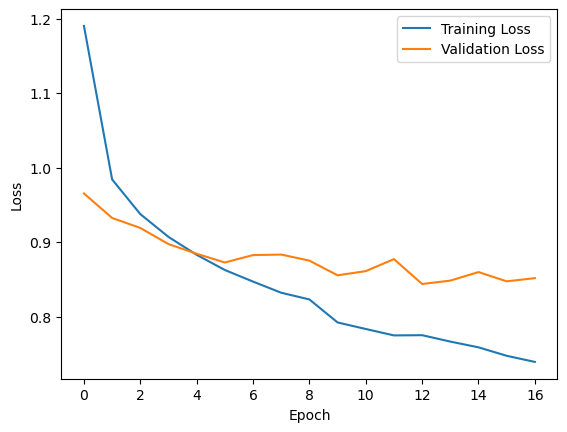

In [19]:
##############################################################################
# TESTING & EVALUATION FOR GPT-2 CAPTIONING
##############################################################################
import matplotlib.pyplot as plt

model_save_path = "best_gpt2_captioning.pt"
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()
print(f"Model loaded from {model_save_path}")

# 1) Plot training/validation loss
train_loss_file = "train_loss_values.json"
val_loss_file   = "val_loss_values.json"

def load_json(filename):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        if not data:
            print(f"Warning: {filename} is empty.")
        return data
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filename}.")
        return None

train_loss_values = load_json(train_loss_file)
val_loss_values   = load_json(val_loss_file)

if train_loss_values is not None and val_loss_values is not None:
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [20]:
# ----------------------------------------------------------------------------
# 2) Compute Test Loss
# ----------------------------------------------------------------------------
test_loss = 0.0
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        # Move to device
        input_ids = batch["input_ids"].to(device)  # [B, seq_len]
        attention_mask = batch["attention_mask"].to(device)  # [B, seq_len]
        labels = input_ids.clone()  # [B, seq_len]

        # Keep the feature shape [B, 3072], no expansion
        features = batch["features"].to(device)
        with torch.cuda.amp.autocast():
            out = model(
                features=features,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
        test_loss += out.loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


  0%|          | 0/67 [00:00<?, ?it/s]C:\Users\Mohamed\AppData\Local\Temp\ipykernel_14900\271586532.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 67/67 [03:56<00:00,  3.54s/it]

Test Loss: 0.8488


In [21]:
##############################################################################
# Define the image transform (same as training)
##############################################################################
import torchvision.transforms as transforms
from PIL import Image
import torch

# Transform for feature extraction: not same as training (without data augmentation)
feature_extraction_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

##############################################################################
# 2) Define helper functions for Swin + DETR feature extraction
##############################################################################
def extract_swin_features(model, image_tensor):
    with torch.no_grad():
        feats = model(image_tensor)  # shape: [batch_size, hidden_dim]
    return feats.view(feats.size(0), -1)  # flatten if necessary

def extract_detr_features(model, image_tensor, target_size=1536):
    with torch.no_grad():
        outputs = model(image_tensor)
        object_queries = outputs.last_hidden_state  # shape [batch_size, num_queries, hidden_dim]
        flattened = object_queries.view(object_queries.size(0), -1)
        # If needed, pool to target_size
        if flattened.size(1) > target_size:
            flattened = torch.nn.functional.adaptive_avg_pool1d(
                flattened.unsqueeze(0),
                target_size
            ).squeeze(0)
    return flattened

##############################################################################
# 3) The missing get_image_features(...) function
##############################################################################
def get_image_features(image_path):
    """
    1. Load + transform the image (same as training).
    2. Pass through Swin & DETR (both in eval mode and on the same device).
    3. Concatenate the two feature vectors -> shape [1, 3072].
    """
    # Load & transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = feature_extraction_transform(image).unsqueeze(0).to(device)

    # Extract Swin features
    swin_feats = extract_swin_features(swin_model, image_tensor)  # [1, 1024] for swin_large_patch4_window7_224
    # Extract DETR features
    detr_feats = extract_detr_features(detr_model, image_tensor, target_size=1536)  # [1, 1536]

    # Concatenate => shape [1, 1024 + 1536 = 2560 or 3072]
    combined_features = torch.cat([swin_feats, detr_feats], dim=1)

    return combined_features


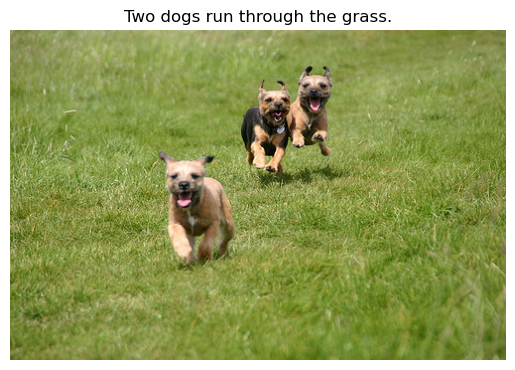


Image: E:\dataset30k\Images\3258874419.jpg


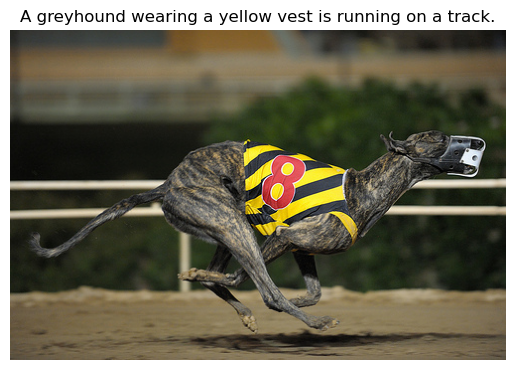

Inference time: 0.900 seconds

Image: E:\dataset30k\Images\405615014.jpg


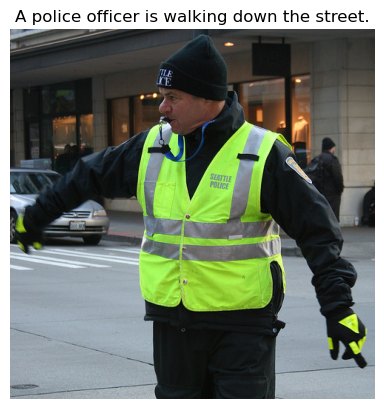

Inference time: 1.036 seconds

Image: E:\dataset30k\Images\3401548798.jpg


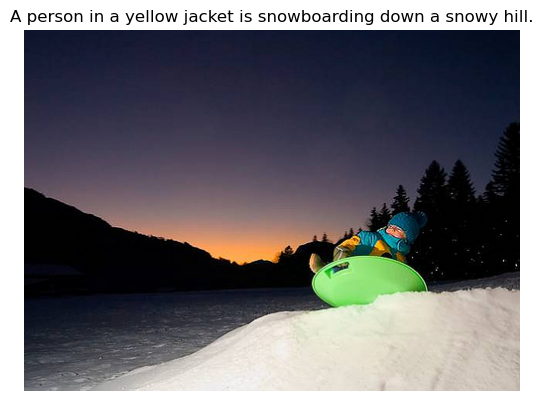

Inference time: 1.075 seconds

Image: E:\dataset30k\Images\2310108346.jpg


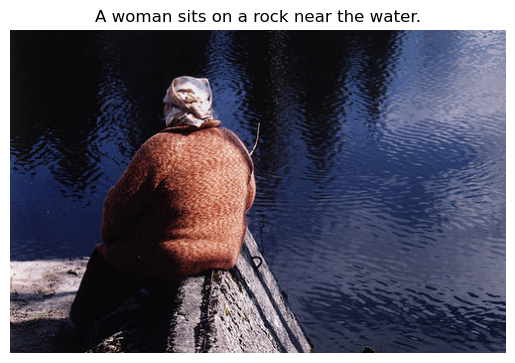

Inference time: 0.802 seconds

Image: E:\dataset30k\Images\3453369116.jpg


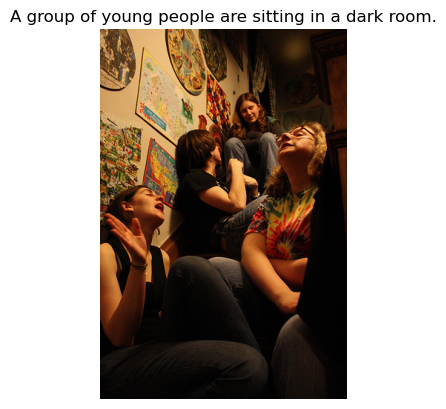

Inference time: 1.073 seconds


In [163]:
# # ----------------------------------------------------------------------------
# # 3) Inference / Caption Generation
# # ----------------------------------------------------------------------------
# def generate_caption(model, tokenizer, features, max_new_tokens=20):
#     """
#     Simple greedy generation with the GPT-2 captioning model.
#     `features` is shape [1, 3072] for a single image.
#     """
#     model.eval()
#     with torch.no_grad():
#         # We start with an empty context (no text), rely on prefix embedding or cross-attention
#         generated_ids = []
#         for _ in range(max_new_tokens):
#             # Convert current generated_ids to input_ids
#             cur_ids = torch.tensor([generated_ids], dtype=torch.long, device=device)
#             # Forward pass
#             outputs = model(
#                 features=features,
#                 input_ids=cur_ids,
#                 attention_mask=torch.ones_like(cur_ids),
#             )
#             logits = outputs.logits  # [1, seq_len, vocab_size]
#             next_token_id = torch.argmax(logits[0, -1, :])
#             generated_ids.append(next_token_id.item())

#             # If EOS, break
#             if next_token_id.item() == tokenizer.eos_token_id:
#                 break

#     # Decode
#     text = tokenizer.decode(generated_ids, skip_special_tokens=True)
#     return text.strip()


def generate_caption(model, tokenizer, features, max_new_tokens=20, beam_size=10):
    """
    Beam search caption generation for GPT-2 style captioning model.
    `features` should be shape [1, 3072] (or appropriate for your setup).
    """
    model.eval()
    with torch.no_grad():
        # Each beam is a tuple: (generated_ids, score)
        beams = [([], 0.0)]  # Start with empty sequence and score 0

        for _ in range(max_new_tokens):
            new_beams = []
            for seq, score in beams:
                input_ids = torch.tensor([seq], dtype=torch.long, device=device)
                outputs = model(
                    features=features,
                    input_ids=input_ids,
                    attention_mask=torch.ones_like(input_ids),
                )
                logits = outputs.logits  # [1, seq_len, vocab_size]
                next_token_logits = logits[0, -1, :]  # [vocab_size]
                probs = torch.log_softmax(next_token_logits, dim=-1)  # log-probs

                topk_probs, topk_ids = torch.topk(probs, beam_size)

                for i in range(beam_size):
                    token_id = topk_ids[i].item()
                    token_prob = topk_probs[i].item()
                    new_seq = seq + [token_id]
                    new_score = score + token_prob  # Add log-probs
                    new_beams.append((new_seq, new_score))

            # Sort beams by score and keep best `beam_size`
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            # Check if all beams ended with EOS
            if all(seq and seq[-1] == tokenizer.eos_token_id for seq, _ in beams):
                break

        # Return the best sequence (highest score)
        best_seq = beams[0][0]
        caption = tokenizer.decode(best_seq, skip_special_tokens=True)
        return caption.strip()


# Example: generate captions for 5 random images
def get_random_images(image_dir, num_images=5):
    all_images = [
        os.path.join(image_dir, img)
        for img in os.listdir(image_dir)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    return random.sample(all_images, num_images)
import time

import time

def generate_and_plot_image(model, tokenizer, image_path):
    try:
        # Precompute image features
        features = get_image_features(image_path)  # Should return [1, 3072]
        features = features.unsqueeze(0).to(device)

        # Measure time before inference
        start_time = time.time()

        # Generate caption
        caption = generate_caption(model, tokenizer, features, max_new_tokens=20, beam_size=5)

        # Measure time after inference
        end_time = time.time()
        inference_time = end_time - start_time

        # Display image and caption
        im = Image.open(image_path).convert('RGB')
        np_img = np.array(im)
        plt.imshow(np_img)
        plt.axis("off")
        plt.title(caption)
        plt.show()

        print(f"Inference time: {inference_time:.3f} seconds")
        return inference_time  # << ADD THIS

    except Exception as e:
        print(f"Error generating caption for {image_path}: {e}")
        return None  # in case of failure

def measure_average_inference_time(model, tokenizer, image_paths):
    times = []
    for img_path in image_paths:
        print(f"\nImage: {img_path}")
        t = generate_and_plot_image(model, tokenizer, img_path)
        if t is not None:
            times.append(t)

    if times:
        avg = sum(times) / len(times)
        print(f"\n✅ Average inference time over {len(times)} images: {avg:.3f} seconds")
    else:
        print("⚠️ No successful inferences to compute average.")


# def generate_and_plot_image(model, tokenizer, image_path):
#     try:
#         # Precompute image features the same way as training
#         # (code: transform + combine Swin + DETR if needed)
#         # Suppose you have a helper function get_image_features(image_path) -> [1,3072]
#         features = get_image_features(image_path)  # Implement similarly to training
#         features = features.unsqueeze(0).to(device)

#         # Generate caption
#         caption = generate_caption(model, tokenizer, features, max_new_tokens=20)

#         # Display
#         im = Image.open(image_path).convert('RGB')
#         np_img = np.array(im)
#         plt.imshow(np_img)
#         plt.axis("off")
#         plt.title(caption)
#         plt.show()
#     except Exception as e:
#         print(f"Error generating caption for {image_path}: {e}")

# def caption_random_images(model, tokenizer, image_dir, num_images=5):
#     random_imgs = get_random_images(image_dir, num_images)
#     for img_path in random_imgs:
#         print(f"\nImage: {img_path}")
#         generate_and_plot_image(model, tokenizer, img_path)

# Example usage
caption_random_images(model, tokenizer, images_dir)


Image: E:\dataset30k\Images\2705103541.jpg


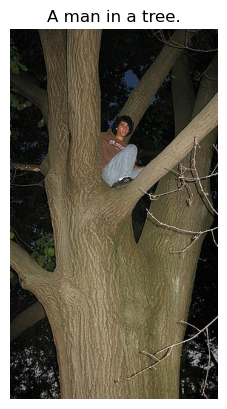

Inference time: 0.614 seconds

Image: E:\dataset30k\Images\2380765956.jpg


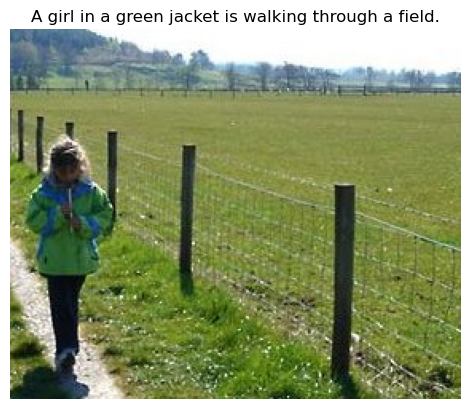

Inference time: 0.863 seconds

Image: E:\dataset30k\Images\3129514177.jpg


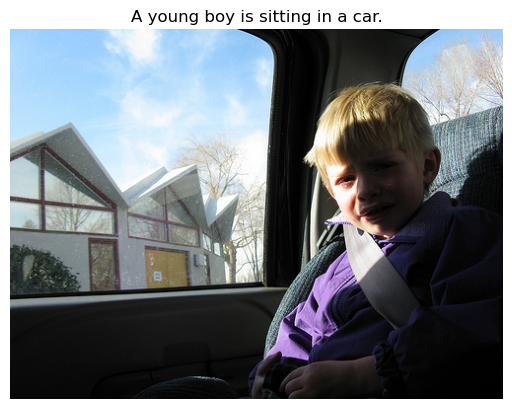

Inference time: 0.674 seconds

Image: E:\dataset30k\Images\477141784.jpg


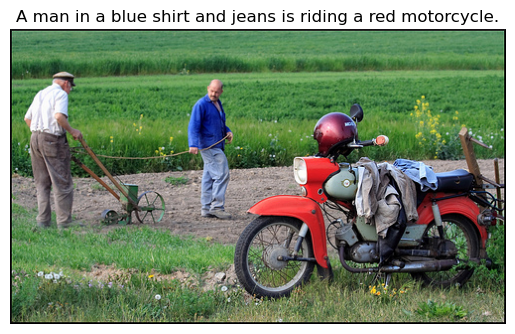

Inference time: 0.827 seconds

Image: E:\dataset30k\Images\2600170955.jpg


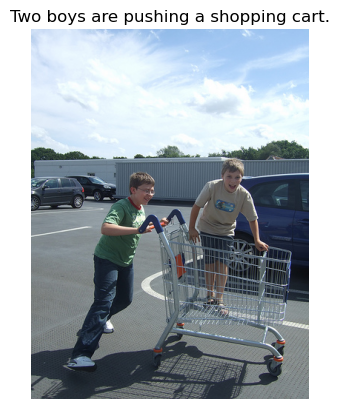

Inference time: 0.759 seconds

Image: E:\dataset30k\Images\122190424.jpg


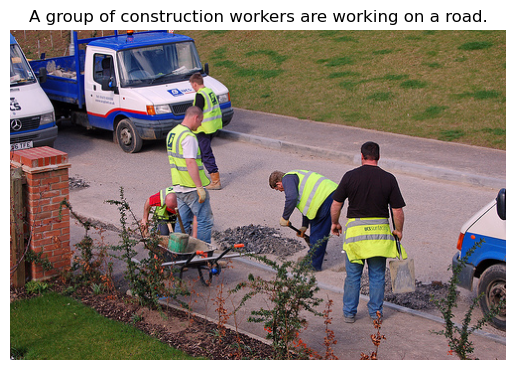

Inference time: 0.863 seconds

Image: E:\dataset30k\Images\336460583.jpg


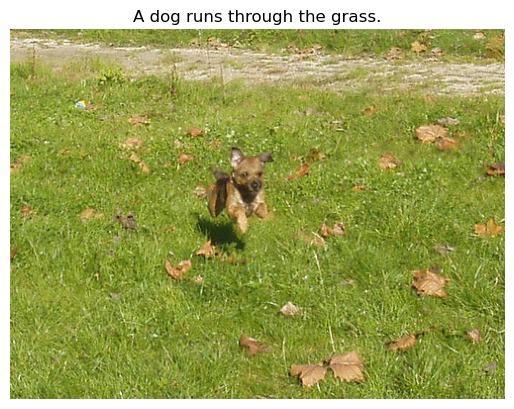

Inference time: 0.737 seconds

Image: E:\dataset30k\Images\100716317.jpg


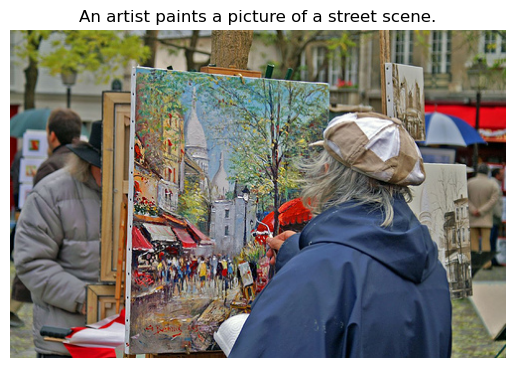

Inference time: 0.678 seconds

Image: E:\dataset30k\Images\27683428.jpg


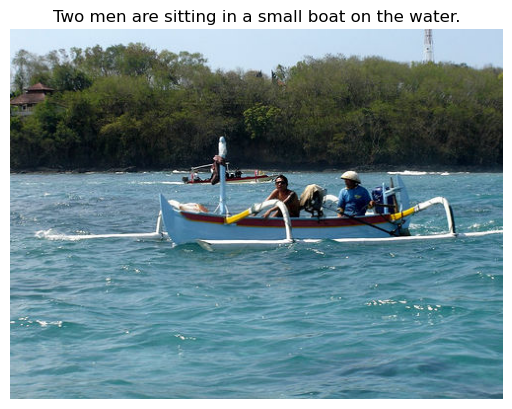

Inference time: 0.896 seconds

Image: E:\dataset30k\Images\4773227009.jpg


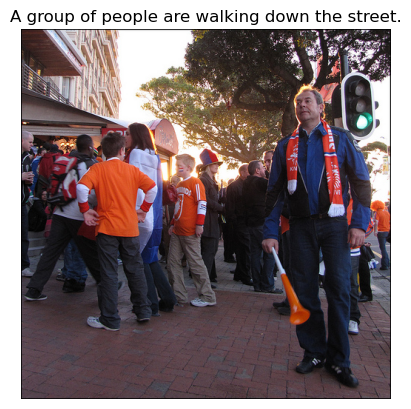

Inference time: 0.908 seconds

✅ Average inference time over 10 images: 0.782 seconds


In [165]:
image_paths = get_random_images(images_dir, num_images=10)
measure_average_inference_time(model, tokenizer, image_paths)

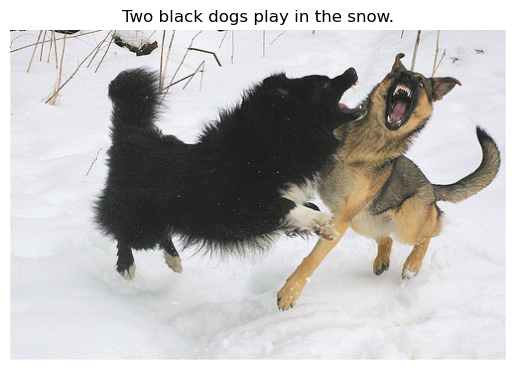

Inference time: 0.513 seconds


0.5128607749938965

In [153]:
image_path = r"E:\dataset\Images\3399312265_9c74378692.jpg"
generate_and_plot_image(model, tokenizer, image_path)

In [23]:
# # ----------------------------------------------------------------------------
# # 3) Inference / Caption Generation
# # ----------------------------------------------------------------------------

# import time
# def generate_caption(model, tokenizer, features, max_new_tokens=20):
#     """
#     Simple greedy generation with the GPT-2 captioning model.
#     `features` is shape [1, 3072] for a single image.
#     """
#     model.eval()
#     with torch.no_grad():
#         start_time = time.time()  # Start timing
#         # We start with an empty context (no text), rely on prefix embedding or cross-attention
#         generated_ids = []
#         for _ in range(max_new_tokens):
#             # Convert current generated_ids to input_ids
#             cur_ids = torch.tensor([generated_ids], dtype=torch.long, device=device)
#             # Forward pass
#             outputs = model(
#                 features=features,
#                 input_ids=cur_ids,
#                 attention_mask=torch.ones_like(cur_ids),
#             )
#             logits = outputs.logits  # [1, seq_len, vocab_size]
#             next_token_id = torch.argmax(logits[0, -1, :])
#             generated_ids.append(next_token_id.item())

#             # If EOS, break
#             if next_token_id.item() == tokenizer.eos_token_id:
#                 break
#         end_time = time.time()  # End timing

#     # Decode
#     text = tokenizer.decode(generated_ids, skip_special_tokens=True)
#     inference_time = end_time - start_time  # Calculate elapsed time
#     print(f"Inference Time: {inference_time:.4f} seconds")
#     return text.strip(), inference_time

# # Example: generate captions for 5 random images
# def get_random_images(image_dir, num_images=5):
#     all_images = [
#         os.path.join(image_dir, img)
#         for img in os.listdir(image_dir)
#         if img.lower().endswith(('.jpg', '.jpeg', '.png'))
#     ]
#     return random.sample(all_images, num_images)

# def generate_and_plot_image(model, tokenizer, image_path):
#     try:
#         # Precompute image features the same way as training
#         # (code: transform + combine Swin + DETR if needed)
#         # Suppose you have a helper function get_image_features(image_path) -> [1,3072]
#         features = get_image_features(image_path)  # Implement similarly to training
#         features = features.to(device)

#         # Generate caption
#         caption, inference_time = generate_caption(model, tokenizer, features, max_new_tokens=20)

#         # Display
#         im = Image.open(image_path).convert('RGB')
#         np_img = np.array(im)
#         plt.imshow(np_img)
#         plt.axis("off")
#         plt.title(f"{caption}\nTime: {inference_time:.4f}s")
#         plt.show()
#     except Exception as e:
#         print(f"Error generating caption for {image_path}: {e}")

# def caption_random_images(model, tokenizer, image_dir, num_images=5):
#     random_imgs = get_random_images(image_dir, num_images)
#     for img_path in random_imgs:
#         print(f"\nImage: {img_path}")
#         generate_and_plot_image(model, tokenizer, img_path)

# # Example usage
# caption_random_images(model, tokenizer, images_dir)

In [167]:
actual_captions = []  # Should be list of lists of lists
predicted_captions = []  # List of tokenized predicted captions

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation metrics"):
        features = batch["features"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Collect multiple references for each image
        batch_references = []  # Store references for the entire batch
        for ref_ids in input_ids:
            ref_text_tokens = tokenizer.convert_ids_to_tokens(
                ref_ids.tolist(),
                skip_special_tokens=True
            )
            batch_references.append(ref_text_tokens)

        # Group references by image (assuming batch size is the same for features & input_ids)
        num_images = features.size(0)
        for i in range(num_images):
            actual_captions.append(batch_references[i::num_images])  # Collect references per image

        # Generate predictions
        for i in range(num_images):
            single_feat = features[i].unsqueeze(0)  # shape [1, 3072]
            pred_text = generate_caption(model, tokenizer, single_feat, max_new_tokens=20)
            pred_text_tokens = tokenizer.tokenize(pred_text)
            predicted_captions.append(pred_text_tokens)

# Ensure actual_captions is a list of lists of lists
assert isinstance(actual_captions, list)
assert all(isinstance(x, list) for x in actual_captions)
assert all(isinstance(x[0], list) for x in actual_captions if x)  # Check for list of lists




Evaluation metrics: 100%|██████████| 67/67 [53:11<00:00, 47.63s/it]


In [168]:
actual_captions

[[['Two',
   'Ġj',
   'oc',
   'keys',
   'Ġrace',
   'Ġto',
   'Ġthe',
   'Ġfinish',
   'Ġline',
   'Ġ.']],
 [['Bl',
   'ond',
   'Ġwomen',
   'Ġin',
   'Ġa',
   'Ġwhite',
   'Ġdress',
   'Ġsitting',
   'Ġon',
   'Ġa',
   'Ġwooden',
   'Ġblank',
   'ed',
   'Ġwalk',
   'way',
   'Ġwith',
   'Ġa',
   'Ġgreen',
   'Ġlined',
   'Ġbackground',
   'Ġ.']],
 [['Women',
   'Ġwearing',
   'Ġa',
   'Ġsilver',
   'Ġwig',
   'Ġbig',
   'Ġglasses',
   'Ġcarrying',
   'Ġa',
   'Ġbasket',
   'Ġwith',
   'Ġcigarette',
   'Ġin',
   'Ġhand',
   'Ġ.']],
 [['Someone', 'Ġclimbs', 'Ġan', 'Ġindoor', 'Ġclimbing', 'Ġwall', 'Ġ.']],
 [['People', 'Ġare', 'Ġstanding', 'Ġshopping', 'Ġin', 'Ġa', 'Ġstore', 'Ġ.']],
 [['A',
   'Ġman',
   'Ġis',
   'Ġsitting',
   'Ġon',
   'Ġa',
   'Ġbench',
   'Ġfacing',
   'Ġthe',
   'Ġmountains',
   'Ġ.']],
 [['A',
   'Ġdog',
   'Ġruns',
   'Ġholding',
   'Ġa',
   'Ġyellow',
   'Ġdog',
   'Ġtoy',
   'Ġin',
   'Ġfall',
   'Ġ,',
   'Ġbench',
   'Ġin',
   'Ġthe',
   'Ġbackground',
   '

In [169]:
actual_captions[:5]

[[['Two',
   'Ġj',
   'oc',
   'keys',
   'Ġrace',
   'Ġto',
   'Ġthe',
   'Ġfinish',
   'Ġline',
   'Ġ.']],
 [['Bl',
   'ond',
   'Ġwomen',
   'Ġin',
   'Ġa',
   'Ġwhite',
   'Ġdress',
   'Ġsitting',
   'Ġon',
   'Ġa',
   'Ġwooden',
   'Ġblank',
   'ed',
   'Ġwalk',
   'way',
   'Ġwith',
   'Ġa',
   'Ġgreen',
   'Ġlined',
   'Ġbackground',
   'Ġ.']],
 [['Women',
   'Ġwearing',
   'Ġa',
   'Ġsilver',
   'Ġwig',
   'Ġbig',
   'Ġglasses',
   'Ġcarrying',
   'Ġa',
   'Ġbasket',
   'Ġwith',
   'Ġcigarette',
   'Ġin',
   'Ġhand',
   'Ġ.']],
 [['Someone', 'Ġclimbs', 'Ġan', 'Ġindoor', 'Ġclimbing', 'Ġwall', 'Ġ.']],
 [['People', 'Ġare', 'Ġstanding', 'Ġshopping', 'Ġin', 'Ġa', 'Ġstore', 'Ġ.']]]

In [170]:
# Ensure captions are proper strings
actual_captions_str = [
    " ".join(map(str, tokens)).replace("Ġ", "") if isinstance(tokens, (list, tuple)) else str(tokens)
    for tokens in actual_captions
]
predicted_captions_str = [
    " ".join(map(str, tokens)).replace("Ġ", "") if isinstance(tokens, (list, tuple)) else str(tokens)
    for tokens in predicted_captions
]

In [171]:
actual_captions[:5]

[[['Two',
   'Ġj',
   'oc',
   'keys',
   'Ġrace',
   'Ġto',
   'Ġthe',
   'Ġfinish',
   'Ġline',
   'Ġ.']],
 [['Bl',
   'ond',
   'Ġwomen',
   'Ġin',
   'Ġa',
   'Ġwhite',
   'Ġdress',
   'Ġsitting',
   'Ġon',
   'Ġa',
   'Ġwooden',
   'Ġblank',
   'ed',
   'Ġwalk',
   'way',
   'Ġwith',
   'Ġa',
   'Ġgreen',
   'Ġlined',
   'Ġbackground',
   'Ġ.']],
 [['Women',
   'Ġwearing',
   'Ġa',
   'Ġsilver',
   'Ġwig',
   'Ġbig',
   'Ġglasses',
   'Ġcarrying',
   'Ġa',
   'Ġbasket',
   'Ġwith',
   'Ġcigarette',
   'Ġin',
   'Ġhand',
   'Ġ.']],
 [['Someone', 'Ġclimbs', 'Ġan', 'Ġindoor', 'Ġclimbing', 'Ġwall', 'Ġ.']],
 [['People', 'Ġare', 'Ġstanding', 'Ġshopping', 'Ġin', 'Ġa', 'Ġstore', 'Ġ.']]]

In [172]:
predicted_captions[:5]

[['Two', 'Ġj', 'oc', 'keys', 'Ġare', 'Ġriding', 'Ġhorses', '.'],
 ['A',
  'Ġwoman',
  'Ġin',
  'Ġa',
  'Ġwhite',
  'Ġdress',
  'Ġis',
  'Ġsitting',
  'Ġon',
  'Ġa',
  'Ġdock',
  '.'],
 ['A',
  'Ġwoman',
  'Ġin',
  'Ġa',
  'Ġpink',
  'Ġwig',
  'Ġstands',
  'Ġin',
  'Ġa',
  'Ġmarketplace',
  '.'],
 ['A', 'Ġman', 'Ġclimbing', 'Ġa', 'Ġwall', '.'],
 ['A',
  'Ġman',
  'Ġin',
  'Ġa',
  'Ġblue',
  'Ġshirt',
  'Ġis',
  'Ġlooking',
  'Ġat',
  'Ġa',
  'Ġman',
  'Ġin',
  'Ġa',
  'Ġgray',
  'Ġshirt',
  '.']]

In [173]:
actual_captions_str[:5]

["['Two', 'j', 'oc', 'keys', 'race', 'to', 'the', 'finish', 'line', '.']",
 "['Bl', 'ond', 'women', 'in', 'a', 'white', 'dress', 'sitting', 'on', 'a', 'wooden', 'blank', 'ed', 'walk', 'way', 'with', 'a', 'green', 'lined', 'background', '.']",
 "['Women', 'wearing', 'a', 'silver', 'wig', 'big', 'glasses', 'carrying', 'a', 'basket', 'with', 'cigarette', 'in', 'hand', '.']",
 "['Someone', 'climbs', 'an', 'indoor', 'climbing', 'wall', '.']",
 "['People', 'are', 'standing', 'shopping', 'in', 'a', 'store', '.']"]

In [174]:
predicted_captions_str[:5]

['Two j oc keys are riding horses .',
 'A woman in a white dress is sitting on a dock .',
 'A woman in a pink wig stands in a marketplace .',
 'A man climbing a wall .',
 'A man in a blue shirt is looking at a man in a gray shirt .']

In [175]:
# Tokenize reference captions (each reference list should be wrapped in another list)
actual_captions = [[ref.split()] for ref in actual_captions_str]  # List of lists

# Tokenize predicted captions
predicted_captions = [pred.split() for pred in predicted_captions_str]  # List of tokenized words

In [176]:
import ast

# Convert the string representation of lists back into actual lists
actual_captions_list = [ast.literal_eval(text) for text in actual_captions_str]

# Ensure BLEU-compatible structure (list of list of lists)
actual_captions= [[tokens] for tokens in actual_captions_list]

In [177]:
actual_captions

[[['Two', 'j', 'oc', 'keys', 'race', 'to', 'the', 'finish', 'line', '.']],
 [['Bl',
   'ond',
   'women',
   'in',
   'a',
   'white',
   'dress',
   'sitting',
   'on',
   'a',
   'wooden',
   'blank',
   'ed',
   'walk',
   'way',
   'with',
   'a',
   'green',
   'lined',
   'background',
   '.']],
 [['Women',
   'wearing',
   'a',
   'silver',
   'wig',
   'big',
   'glasses',
   'carrying',
   'a',
   'basket',
   'with',
   'cigarette',
   'in',
   'hand',
   '.']],
 [['Someone', 'climbs', 'an', 'indoor', 'climbing', 'wall', '.']],
 [['People', 'are', 'standing', 'shopping', 'in', 'a', 'store', '.']],
 [['A',
   'man',
   'is',
   'sitting',
   'on',
   'a',
   'bench',
   'facing',
   'the',
   'mountains',
   '.']],
 [['A',
   'dog',
   'runs',
   'holding',
   'a',
   'yellow',
   'dog',
   'toy',
   'in',
   'fall',
   ',',
   'bench',
   'in',
   'the',
   'background',
   '.']],
 [['A',
   'boy',
   'is',
   'jumping',
   'over',
   'shallow',
   'water',
   'near',
   'som

In [178]:
actual_captions

[[['Two', 'j', 'oc', 'keys', 'race', 'to', 'the', 'finish', 'line', '.']],
 [['Bl',
   'ond',
   'women',
   'in',
   'a',
   'white',
   'dress',
   'sitting',
   'on',
   'a',
   'wooden',
   'blank',
   'ed',
   'walk',
   'way',
   'with',
   'a',
   'green',
   'lined',
   'background',
   '.']],
 [['Women',
   'wearing',
   'a',
   'silver',
   'wig',
   'big',
   'glasses',
   'carrying',
   'a',
   'basket',
   'with',
   'cigarette',
   'in',
   'hand',
   '.']],
 [['Someone', 'climbs', 'an', 'indoor', 'climbing', 'wall', '.']],
 [['People', 'are', 'standing', 'shopping', 'in', 'a', 'store', '.']],
 [['A',
   'man',
   'is',
   'sitting',
   'on',
   'a',
   'bench',
   'facing',
   'the',
   'mountains',
   '.']],
 [['A',
   'dog',
   'runs',
   'holding',
   'a',
   'yellow',
   'dog',
   'toy',
   'in',
   'fall',
   ',',
   'bench',
   'in',
   'the',
   'background',
   '.']],
 [['A',
   'boy',
   'is',
   'jumping',
   'over',
   'shallow',
   'water',
   'near',
   'som

In [192]:
# Compute corpus BLEU
bleu1 = corpus_bleu(actual_captions, predicted_captions, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
bleu2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
bleu3 = corpus_bleu(actual_captions, predicted_captions, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
bleu4 = corpus_bleu(actual_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
avg_bleu = (bleu1 + bleu2 + bleu3 + bleu4) / 4.0
print(f"Average BLEU: {avg_bleu:.4f}")


TypeError: Fraction.__new__() got an unexpected keyword argument '_normalize'

In [ ]:
predicted_captions

In [ ]:
# Compute corpus BLEU (now correctly comparing each prediction to multiple references)
bleu1 = corpus_bleu(actual_captions, predicted_captions, weights=(1,0,0,0), smoothing_function=smoothing_function)
bleu2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5,0.5,0,0), smoothing_function=smoothing_function)
bleu3 = corpus_bleu(actual_captions, predicted_captions, weights=(0.33,0.33,0.33,0), smoothing_function=smoothing_function)
bleu4 = corpus_bleu(actual_captions, predicted_captions, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing_function)

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
avg_bleu = (bleu1+bleu2+bleu3+bleu4)/4.0
print(f"Average BLEU: {avg_bleu:.4f}")

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

rouge_l_f1_scores = []
for ref_tokens, hyp_tokens in zip(actual_captions_str, predicted_captions_str):
    # Flatten the lists if they contain nested lists
    ref_text = " ".join([word for sublist in ref_tokens for word in sublist]) if isinstance(ref_tokens[0], list) else " ".join(ref_tokens)
    hyp_text = " ".join([word for sublist in hyp_tokens for word in sublist]) if isinstance(hyp_tokens[0], list) else " ".join(hyp_tokens)

    # Compute ROUGE-L score
    score = scorer.score(ref_text, hyp_text)['rougeL']
    rouge_l_f1_scores.append(score.fmeasure)

# Compute the average ROUGE-L F1 score
avg_rouge_l_f1 = np.mean(rouge_l_f1_scores)
print(f"Average ROUGE-L F1 Score: {avg_rouge_l_f1:.4f}")


In [ ]:
from pycocoevalcap.cider.cider import Cider

# # Ensure each caption is a string, handling nested lists
# actual_captions_str = [
#     " ".join(word for sublist in tokens for word in sublist) if isinstance(tokens[0], list) else " ".join(tokens)
#     for tokens in actual_captions
# ]

# predicted_captions_str = [
#     " ".join(word for sublist in tokens for word in sublist) if isinstance(tokens[0], list) else " ".join(tokens)
#     for tokens in predicted_captions
# ]

# Build dictionaries in the format expected by the CIDEr evaluator:
gts = {img_id: [ref] for img_id, ref in zip(image_ids, actual_captions_str)}
res = {img_id: [pred] for img_id, pred in zip(image_ids, predicted_captions_str)}

# Initialize the CIDEr evaluator
cider_evaluator = Cider()

# Compute the CIDEr score
score, scores = cider_evaluator.compute_score(gts, res)
print(f"CIDEr Score: {score:.4f}")
